In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2022-07-24 09:07:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   109MB/s    in 1.3s    

2022-07-24 09:07:32 (109 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [3]:
import zipfile

In [4]:
path_to_data = '/tmp/horse-or-human.zip'

In [5]:
zip_ref = zipfile.ZipFile(path_to_data, 'r')

In [6]:
zip_ref.extractall('/tmp/horse-or-human')

In [7]:
zip_ref.close()

In [8]:
import os

In [11]:
len(os.listdir('/tmp/horse-or-human/horses'))

500

In [12]:
len(os.listdir('/tmp/horse-or-human/humans'))

527

In [13]:
import tensorflow as tf

In [38]:
batch_size = 16
img_height = 224
img_width = 224

In [39]:
train = tf.keras.utils.image_dataset_from_directory(
  directory = '/tmp/horse-or-human',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size  
)

validation = tf.keras.utils.image_dataset_from_directory(
  directory = '/tmp/horse-or-human',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size  
)

Found 1027 files belonging to 2 classes.
Using 822 files for training.
Found 1027 files belonging to 2 classes.
Using 205 files for validation.


In [40]:
class_names = validation.class_names
class_names

['horses', 'humans']

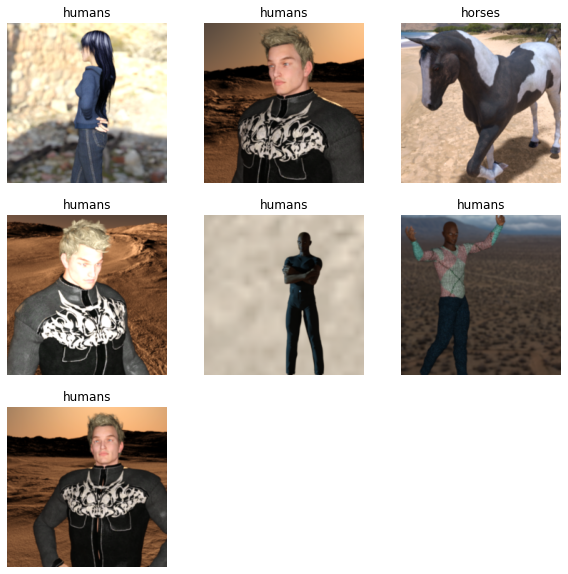

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(7):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [42]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [45]:
import tensorflow_hub as hub

In [46]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape = (224, 224, 3),
    trainable = False
)

In [47]:
model = tf.keras.models.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
class_names

['horses', 'humans']

In [54]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['acc'])

In [55]:
model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
52/52 [==============================] - 29s 518ms/step - loss: 0.5181 - acc: 0.7433 - val_loss: 0.4297 - val_acc: 0.8244
Epoch 2/10
52/52 [==============================] - 27s 511ms/step - loss: 0.3402 - acc: 0.8796 - val_loss: 0.2531 - val_acc: 0.9512
Epoch 3/10
52/52 [==============================] - 27s 508ms/step - loss: 0.2479 - acc: 0.9392 - val_loss: 0.2040 - val_acc: 0.9659
Epoch 4/10
52/52 [==============================] - 27s 509ms/step - loss: 0.1985 - acc: 0.9574 - val_loss: 0.1589 - val_acc: 0.9854
Epoch 5/10
52/52 [==============================] - 27s 503ms/step - loss: 0.1650 - acc: 0.9745 - val_loss: 0.1467 - val_acc: 0.9854
Epoch 6/10
52/52 [==============================] - 27s 510ms/step - loss: 0.1442 - acc: 0.9745 - val_loss: 0.1198 - val_acc: 0.9902
Epoch 7/10
52/52 [==============================] - 27s 514ms/step - loss: 0.1242 - acc: 0.9842 - val_loss: 0.1106 - val_acc: 0.9902
Epoch 8/10
52/52 [==============================] - 27s 509ms/step - 

In [72]:
import numpy as np

test_image = np.array(image_batch[0]).astype('int')
test_image.shape

(224, 224, 3)

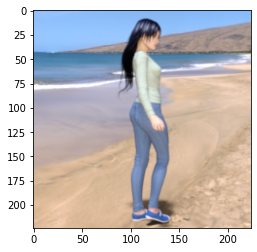

In [70]:
plt.imshow(test_image)

In [76]:
model.predict(
    tf.expand_dims(test_image, 0)
)

array([[0.9136417]], dtype=float32)

In [77]:
class_names

['horses', 'humans']